In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install tensorflow_addons

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import os


d:\miniconda\envs\DL4Met\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
d:\miniconda\envs\DL4Met\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [3]:

# Set the path to your image folder
folder_path = 'H:/0801/pen1top/Depth/20230801_140001'

# List all files
images = []
for filename in os.listdir(folder_path):
    if filename.endswith('.png'):  # Check the file format
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).convert('L')  # 'L' mode means grayscale
        images.append(img)

# Convert images to array and resize
image_size = 224
processed_images = np.array([img_to_array(img.resize((image_size, image_size))) for img in images])

# Normalize the image data
processed_images = processed_images / 255.0


In [6]:
processed_images.shape

(106, 224, 224, 1)

In [8]:
# Convert weight array to a NumPy array
weights = [np.random.randint(0, 100) for i in range(processed_images.shape[0])] #要改成实际输入的weight
weights = np.array(weights)

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(processed_images, weights, test_size=0.2, random_state=42)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


num_classes = 1
input_shape = (224, 224, 1)

In [9]:
# Configure hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 4
num_epochs = 10
patience = 5
image_size = 224
patch_size = 5
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]


In [14]:
os.getcwd()

'd:\\OneDrive_VT\\OneDrive - Virginia Tech\\Research\\Codes\\research\\PigBW\\AdCVFinal'

In [15]:

# Data augmentation
# Uncomment and modify the following lines if data augmentation is needed

# Multilayer Perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Layer to extract image patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Define Patch Encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Create ViT Regressor model
def create_vit_regressor():
    inputs = layers.Input(shape=input_shape)
    augmented = inputs
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    output = layers.Dense(1, activation='linear')(features)  # Linear activation function in output layer

    model = keras.Model(inputs=inputs, outputs=output)
    return model

# Define Mean Squared Error loss function
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define Mean Absolute Error metric
def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Run regression experiment
def run_regression_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=mean_squared_error,
        metrics=[mean_absolute_error]
    )

    checkpoint_filepath = "../tmp/checkpoint/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        patience=patience
    )

    hist = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    # Plot the training curve
    # plt.plot(hist.history['loss'])
    # plt.plot(hist.history['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['train', 'val'], loc='upper right')
    # plt.show()
    # plt.plot(hist.history['accuracy'])
    # plt.plot(hist.history['val_accuracy'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['train', 'val'], loc='lower right')
    # plt.show()
    model.load_weights(checkpoint_filepath)
    test_loss, test_mae = model.evaluate(x_test, y_test)
    print(f"Test loss: {test_loss}")
    print(f"Test MAE: {test_mae}")

    return hist


In [16]:
# Create and run regression experiment with ViT regressor
vit_regressor = create_vit_regressor()
hist = run_regression_experiment(vit_regressor)

Epoch 1/10
19/19 [==============================] - 15s 520ms/step - loss: 37570.6953 - mean_absolute_error: 137.3990 - val_loss: 14477.0244 - val_mean_absolute_error: 121.7584
Epoch 2/10
19/19 [==============================] - 4s 214ms/step - loss: 13922.7373 - mean_absolute_error: 90.5827 - val_loss: 64986.0820 - val_mean_absolute_error: 250.2446
Epoch 3/10
19/19 [==============================] - 9s 484ms/step - loss: 22315.0156 - mean_absolute_error: 115.8551 - val_loss: 8910.8525 - val_mean_absolute_error: 88.3017
Epoch 4/10
19/19 [==============================] - 9s 494ms/step - loss: 8708.0488 - mean_absolute_error: 75.4676 - val_loss: 2075.6006 - val_mean_absolute_error: 43.2031
Epoch 5/10
19/19 [==============================] - 9s 491ms/step - loss: 4214.7915 - mean_absolute_error: 50.6053 - val_loss: 520.3713 - val_mean_absolute_error: 18.1012
Epoch 6/10
19/19 [==============================] - 4s 222ms/step - loss: 2683.3274 - mean_absolute_error: 40.7857 - val_loss: 836.

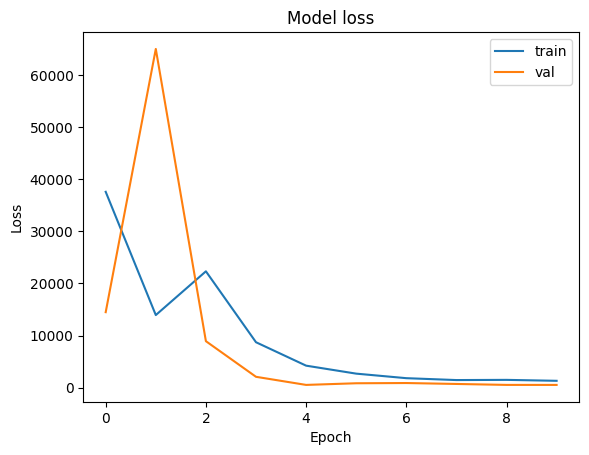

In [17]:
# Plot the training curve
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


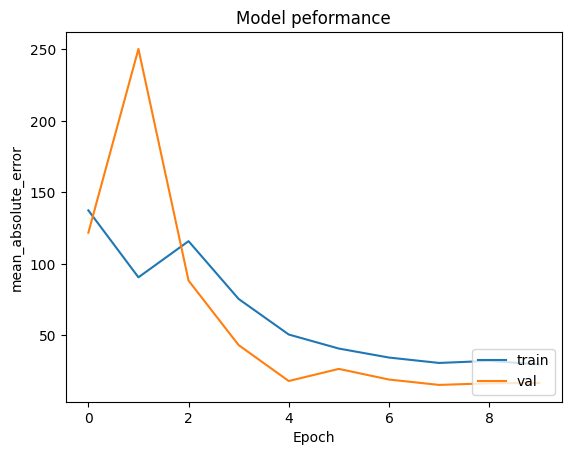

In [18]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model peformance')
plt.ylabel('mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()